# Transport Network Properties

This notebook analyzes the structural properties of the Bicol transport network. It computes node and edge centrality metrics to identify influential points and links, and also detects distinct network communities.

## 0 Preliminaries

In [1]:
import os
import warnings

import contextily as cx
import geopandas as gpd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, LogLocator

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = "./outputs"
GDF_BOUNDS = gpd.read_file(os.path.join(BASE_PATH, "boundaries.gpkg"))
GRAPH_TRANSPORT = ox.load_graphml(os.path.join(BASE_PATH, "merged_network_simplified.graphml"))

In [3]:
def plot_with_basemap(
    ax: Axes,
    title: str,
    filename: str = None,
    padding: float = 0.1,
    basemap: bool = True,
) -> None:
    if basemap:
        x_min, y_min, x_max, y_max = GDF_BOUNDS.total_bounds
        ax.set_xlim(x_min - padding, x_max + padding)
        ax.set_ylim(y_min - padding, y_max + padding)

        cx.add_basemap(
            ax,
            crs=GDF_BOUNDS.crs,
            source=cx.providers.CartoDB.Positron,
            attribution="",
        )

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()

    if filename:
        filepath = os.path.join(BASE_PATH, filename)
        plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()


def plot_choropleth(
    ax: Axes,
    gdf: gpd.GeoDataFrame,
    column: str,
    title: str,
    cmap: str,
    filename: str = None,
    basemap: bool = True,
    cbar: bool = True,
):
    data = gdf[column].replace(0, np.nan).dropna()
    vmin = max(data.min(), 1e-8)
    vmax = data.max()

    norm = LogNorm(vmin=vmin, vmax=vmax)

    formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
    locator = LogLocator(base=10.0, numticks=3)

    legend_kwds = {
        "label": f"Log-Scaled Average {' '.join(column.split('_')).title()}",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.5,
        "format": formatter,
        "ticks": locator.tick_values(vmin, vmax),
    }

    gdf.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        edgecolor="white",
        linewidth=0.5,
        legend=cbar,
        legend_kwds=legend_kwds,
        norm=norm,
    )

    plot_with_basemap(ax=ax, title=title, filename=filename, basemap=basemap)

## 1 Analyze node distribution 

In [4]:
gdf_nodes = ox.graph_to_gdfs(GRAPH_TRANSPORT, edges=False)[["geometry"]]
gdf_nodes = gpd.sjoin(gdf_nodes, GDF_BOUNDS, how="inner", predicate="within")
gdf_nodes = gdf_nodes.drop(columns=["index_right"])
gdf_nodes.head()

,geometry,town,province
osmid,,,
300744370,POINT (124.03376 11.76261),Esperanza,Masbate
300744933,POINT (124.06395 11.76468),Pio V. Corpus,Masbate
300744970,POINT (124.05778 11.86383),Pio V. Corpus,Masbate
300745522,POINT (123.90828 11.91029),Placer,Masbate
300746507,POINT (123.99164 11.96455),Cataingan,Masbate


In [5]:
def compute_node_counts_by_town(
    gdf_metrics: gpd.GeoDataFrame,
    gdf_nodes: gpd.GeoDataFrame,
    col: str = "node_count",
) -> pd.DataFrame:
    df_node_counts = gdf_nodes.groupby(["town"]).size().reset_index(name=col)
    return gdf_metrics.merge(df_node_counts, on=["town"], how="left")


gdf_metrics = compute_node_counts_by_town(GDF_BOUNDS.copy(), gdf_nodes)

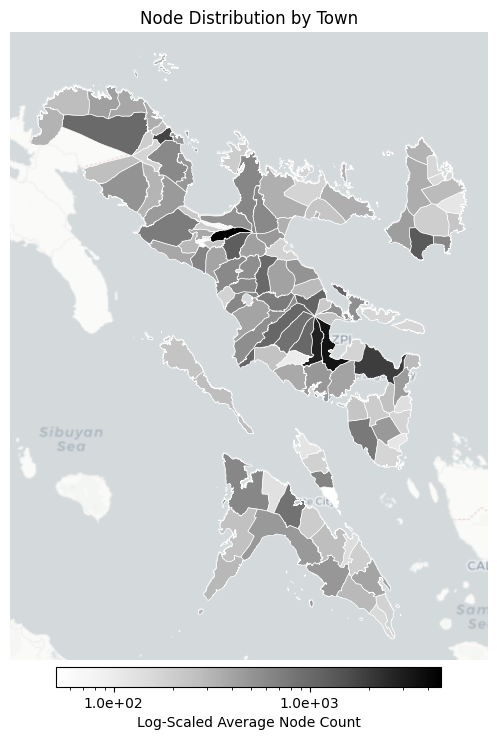

In [6]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="node_count",
    title="Node Distribution by Town",
    cmap="Greys",
    filename="node_count_map.png",
)

In [7]:
def networkx_to_igraph(nx_graph: nx.Graph) -> ig.Graph:
    nx_nodes = list(nx_graph.nodes)
    node_index = {node: idx for idx, node in enumerate(nx_nodes)}

    ig_edges = [(node_index[u], node_index[v]) for u, v in nx_graph.edges()]
    graph = ig.Graph(edges=ig_edges, directed=False)
    graph.vs["name"] = [str(n) for n in nx_nodes]

    return graph, list(node_index.keys())


graph_ig, node_index = networkx_to_igraph(GRAPH_TRANSPORT)

Detected 250 communities.


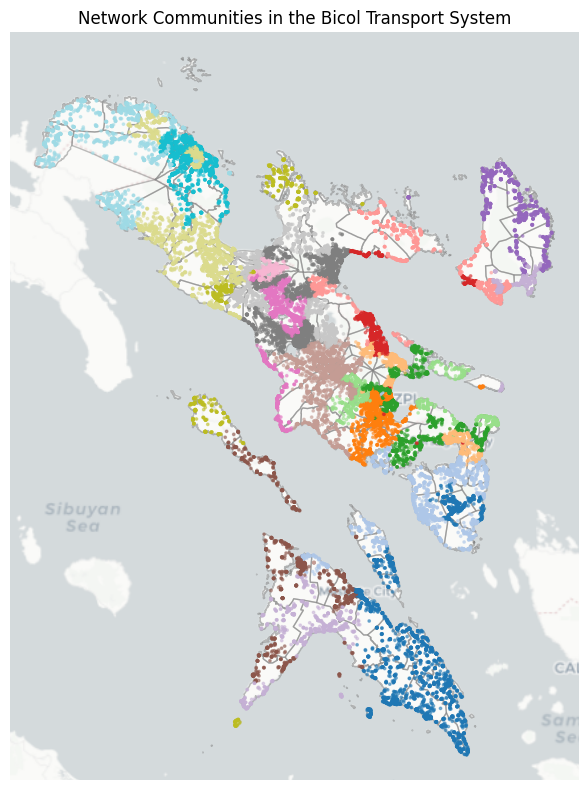

In [8]:
def get_communities(graph: ig.Graph) -> pd.DataFrame:
    communities = graph.community_multilevel()  # Uses multilevel (Louvain) algorithm
    df_communities = pd.DataFrame(
        {
            "osmid": [int(v["name"]) for v in graph.vs],
            "community_id": communities.membership,
        }
    )
    print(f"Detected {len(communities)} communities.")
    return df_communities


def plot_communities_map(
    gdf_nodes: gpd.GeoDataFrame,
    df_communities: pd.DataFrame,
) -> None:
    gdf_nodes_w_communities = gdf_nodes.reset_index().merge(df_communities, on="osmid")

    _, ax = plt.subplots(figsize=(8, 8))

    GDF_BOUNDS.plot(ax=ax, color="none", edgecolor="gray", linewidth=1, zorder=2, alpha=0.5)

    gdf_nodes_w_communities.plot(
        column="community_id",
        categorical=True,
        ax=ax,
        markersize=3,
        cmap="tab20",
        zorder=3,
        alpha=0.5,
    )

    plot_with_basemap(
        ax=ax,
        title="Network Communities in the Bicol Transport System",
        filename="network_communities_map.png",
        basemap=True,
    )


df_communities = get_communities(graph_ig)
plot_communities_map(gdf_nodes, df_communities)

## 2 Compute centrality metrics for all nodes

In [9]:
try:
    df_centrality = pd.read_csv(os.path.join(BASE_PATH, "node_metrics.csv"))
except FileNotFoundError:
    degree_raw = graph_ig.degree()
    closeness_raw = graph_ig.closeness(normalized=True)
    betweenness_raw = graph_ig.betweenness()

    n = graph_ig.vcount()
    degree_norm = [d / (n - 1) for d in degree_raw]
    betweenness_norm = [b / ((n - 1) * (n - 2)) if n > 2 else 0 for b in betweenness_raw]

    centralities = {
        "osmid": node_index,
        "degree": degree_norm,
        "closeness": closeness_raw,
        "betweenness": betweenness_norm,
    }

    df_centrality = pd.DataFrame(centralities)

df_centrality.head()

,osmid,degree,closeness,betweenness
0,300744370,0.000053,0.003144,0.001964
1,300744933,0.000053,0.003096,0.001374
2,300744970,0.000053,0.003235,0.000093
3,300745522,0.000053,0.003578,0.001914
4,300746507,0.000053,0.003505,0.001660


In [10]:
df_centrality.to_csv(os.path.join(BASE_PATH, "node_metrics.csv"), index=False)

## 3 Compute average metrics for each town

In [11]:
def get_town_metrics(
    gdf_metrics: gpd.GeoDataFrame,
    gdf_nodes: gpd.GeoDataFrame,
    df_centrality: pd.DataFrame,
) -> gpd.GeoDataFrame:
    df_merged = pd.merge(gdf_nodes, df_centrality, on="osmid")
    agg_metrics = {"degree": "mean", "betweenness": "mean", "closeness": "mean"}
    df_town_metrics = df_merged.groupby(["town"]).agg(agg_metrics).reset_index()
    cols = ["town", "province", "degree", "betweenness", "closeness", "geometry"]
    return gdf_metrics.merge(df_town_metrics, on=["town"])[cols]


gdf_metrics = get_town_metrics(gdf_metrics, gdf_nodes, df_centrality)

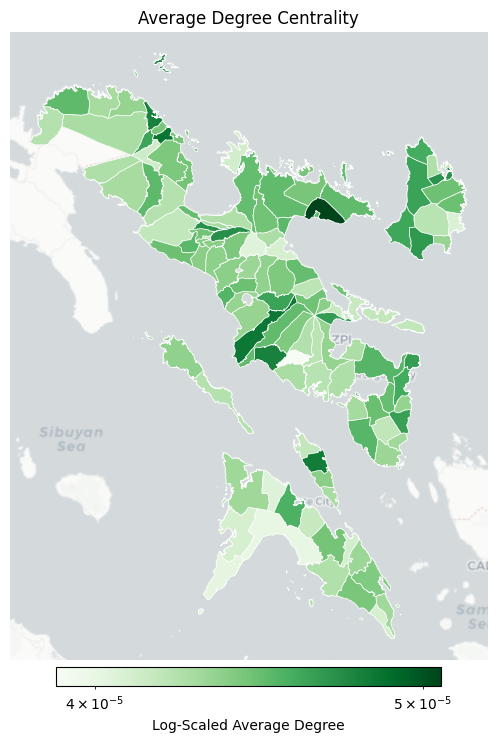

In [12]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="degree",
    title="Average Degree Centrality",
    cmap="Greens",
    filename="degree_centrality_map.png",
)

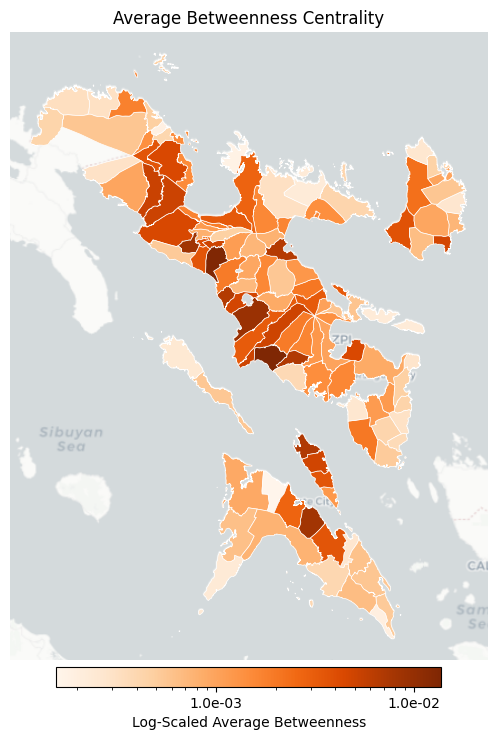

In [13]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="betweenness",
    title="Average Betweenness Centrality",
    cmap="Oranges",
    filename="betweenness_centrality_map.png",
)

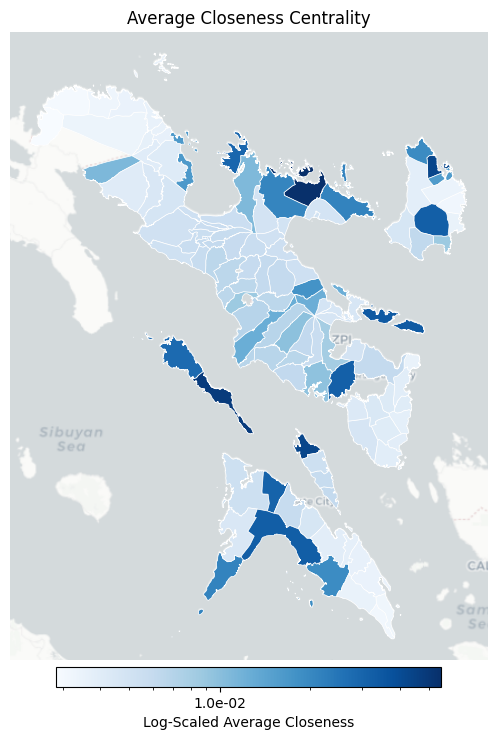

In [14]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="closeness",
    title="Average Closeness Centrality",
    cmap="Blues",
    filename="closeness_centrality_map.png",
)

In [16]:
def get_top_towns_by_centrality(
    gdf_metrics: gpd.GeoDataFrame,
    metric: str,
    top_n: int = 20,
) -> pd.DataFrame:
    return (
        gdf_metrics.nlargest(top_n, metric)[["town", "province", metric]]
        .sort_values(by=metric, ascending=False)
        .reset_index(drop=True)
    )


top_degree_towns = get_top_towns_by_centrality(gdf_metrics, "degree")
top_betweenness_towns = get_top_towns_by_centrality(gdf_metrics, "betweenness")
top_closeness_towns = get_top_towns_by_centrality(gdf_metrics, "closeness")

print("Top Towns by Degree Centrality:")
print(top_degree_towns)

print("\nTop Towns by Betweenness Centrality:")
print(top_betweenness_towns)

print("\nTop Towns by Closeness Centrality:")
print(top_closeness_towns)

Top Towns by Degree Centrality:
             town         province    degree
0    Presentacion    Camarines Sur  0.000051
1            Daet  Camarines Norte  0.000049
2             Oas            Albay  0.000048
3     San Jacinto          Masbate  0.000048
4         Vinzons  Camarines Norte  0.000048
5       Pio Duran            Albay  0.000048
6       Naga City    Camarines Sur  0.000047
7         Magarao    Camarines Sur  0.000047
8      Panganiban      Catanduanes  0.000047
9           Virac      Catanduanes  0.000047
10  Santo Domingo            Albay  0.000047
11    Prieto Diaz         Sorsogon  0.000046
12        Bulusan         Sorsogon  0.000046
13       Polangui            Albay  0.000046
14      Caramoran      Catanduanes  0.000046
15    San Vicente  Camarines Norte  0.000046
16     San Andres      Catanduanes  0.000046
17          Gubat         Sorsogon  0.000046
18         Pandan      Catanduanes  0.000046
19   Masbate City          Masbate  0.000046

Top Towns by Betweenne

## 4 Analyze edge metrics

Computed edge betweenness for 71895 edges.
Identified 719 critical edges (top 1.0%) with betweenness >= 0.065309


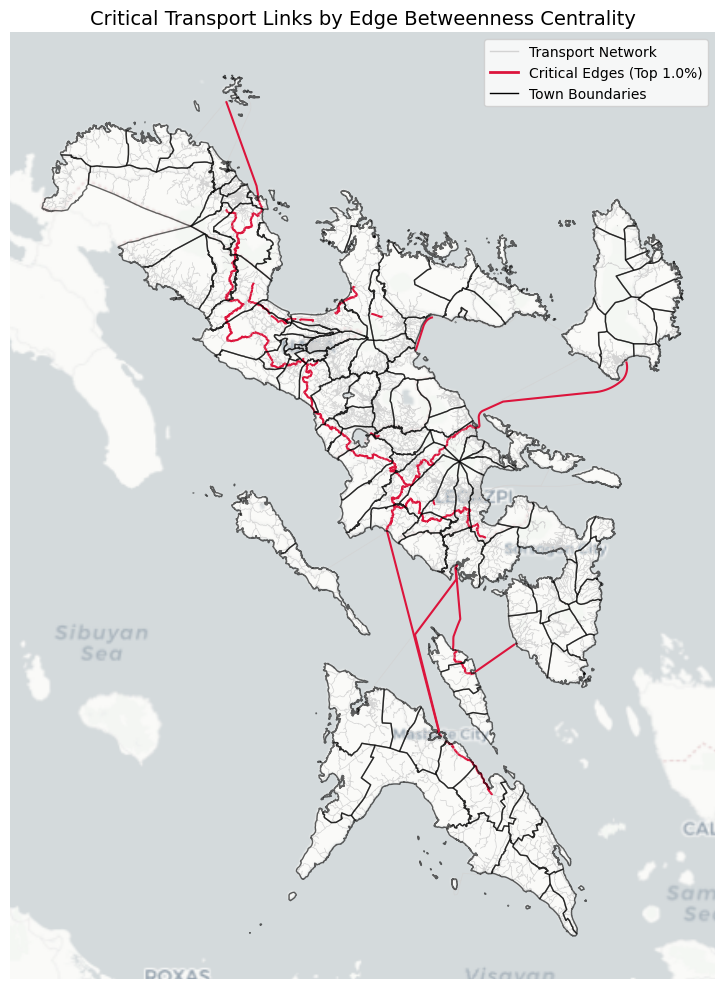

In [17]:
def get_edge_betweenness(nx_graph: nx.Graph, ig_graph: ig.Graph) -> gpd.GeoDataFrame:
    _, gdf_edges = ox.graph_to_gdfs(nx_graph)

    edge_betweenness_raw = ig_graph.edge_betweenness()

    n = ig_graph.vcount()
    if n > 2:
        normalizing_factor = (n * (n - 1)) / 2
        edge_betweenness_norm = [b / normalizing_factor for b in edge_betweenness_raw]
    else:
        edge_betweenness_norm = [0] * len(edge_betweenness_raw)

    gdf_edges["edge_betweenness"] = edge_betweenness_norm

    print(f"Computed edge betweenness for {len(gdf_edges)} edges.")
    return gdf_edges


def plot_edge_betweenness_map(gdf_edges: gpd.GeoDataFrame) -> None:
    criticality_percentile = 0.99
    betweenness_threshold = gdf_edges["edge_betweenness"].quantile(criticality_percentile)
    gdf_critical_edges = gdf_edges[gdf_edges["edge_betweenness"] >= betweenness_threshold]

    print(
        f"Identified {len(gdf_critical_edges)} critical edges (top {100 - criticality_percentile*100:.1f}%) "
        f"with betweenness >= {betweenness_threshold:.6f}"
    )

    _, ax = plt.subplots(figsize=(10, 10))

    gdf_edges.plot(ax=ax, linewidth=0.5, edgecolor="#d3d3d3", zorder=2)
    gdf_critical_edges.plot(ax=ax, linewidth=1.5, edgecolor="crimson", zorder=3)
    GDF_BOUNDS.plot(ax=ax, color="none", edgecolor="black", linewidth=1.0, zorder=4, alpha=0.6)
    cx.add_basemap(ax, crs=gdf_edges.crs, source=cx.providers.CartoDB.Positron, attribution="", zorder=1)

    legend_elements = [
        Line2D([0], [0], color="#d3d3d3", lw=1, label="Transport Network"),
        Line2D(
            [0],
            [0],
            color="crimson",
            lw=2,
            label=f"Critical Edges (Top {100-criticality_percentile*100:.1f}%)",
        ),
        Line2D([0], [0], color="black", lw=1, label="Town Boundaries"),
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    ax.set_title("Critical Transport Links by Edge Betweenness Centrality", fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()

    filepath = os.path.join(BASE_PATH, "edge_betweenness_map.png")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()


gdf_edges_centrality = get_edge_betweenness(GRAPH_TRANSPORT, graph_ig)
plot_edge_betweenness_map(gdf_edges_centrality)

In [26]:
# --- Code Cell 16 ---
def get_critical_edges(gdf_edges: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Filters edges to include only those considered 'critical' based on a percentile."""
    criticality_percentile = 0.99
    betweenness_threshold = gdf_edges["edge_betweenness"].quantile(criticality_percentile)
    return gdf_edges[gdf_edges["edge_betweenness"] >= betweenness_threshold]


def count_critical_edges_by_town(
    gdf_critical_edges: gpd.GeoDataFrame, gdf_boundaries: gpd.GeoDataFrame
) -> pd.DataFrame:
    """Counts the number of critical edges within each town by performing a spatial join."""
    # The sjoin operation finds which town each edge intersects with
    gdf_located_edges = gpd.sjoin(gdf_critical_edges, gdf_boundaries, how="inner", predicate="intersects")

    # Group by both province and town, then count the number of edges
    df_counts = gdf_located_edges.groupby(["province", "town"]).size().reset_index(name="critical_edge_count")

    # Sort the results to find the towns with the most critical edges
    df_counts = df_counts.sort_values(by="critical_edge_count", ascending=False)

    return df_counts


# Identify critical edges from the centrality analysis
gdf_critical_edges = get_critical_edges(gdf_edges_centrality)

# Count the critical edges per town and include the province
df_critical_edge_counts = count_critical_edges_by_town(gdf_critical_edges, GDF_BOUNDS)

# Print the top 20 results
print("--- Top 20 Towns with Most Critical Edges ---")
print(df_critical_edge_counts.head(20).to_string(index=False))

--- Top 20 Towns with Most Critical Edges ---
       province         town  critical_edge_count
          Albay   Ligao City                   62
          Albay  Tabaco City                   54
  Camarines Sur     Libmanan                   53
Camarines Norte        Basud                   49
  Camarines Sur    Minalabac                   38
        Masbate         Mobo                   38
          Albay    Pio Duran                   35
          Albay       Daraga                   32
  Camarines Sur     Pamplona                   31
  Camarines Sur San Fernando                   30
  Camarines Sur      Sipocot                   26
          Albay        Libon                   23
  Camarines Sur         Lupi                   22
  Camarines Sur    Calabanga                   20
        Masbate         Uson                   19
  Camarines Sur     Tinambac                   19
        Masbate      Monreal                   18
          Albay Legazpi City                   18
    